In [1]:
import numpy as np
import jax
from jax import numpy as jnp

import distrax
import haiku as hk

from ima.upsampling import Pad

from jax.experimental.optimizers import adam

from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
key = jax.random.PRNGKey(1)

In [3]:
d = 10
D = 1000
N = 10000

key, subkey = jax.random.split(key)
sources = jax.random.normal(subkey, shape=(N, d))

key, subkey = jax.random.split(key)
A = jax.random.normal(subkey, shape=(D, d)) / np.sqrt(d)

mv = lambda m, v: jnp.matmul(m, v)
mbv = jax.vmap(mv, (None, 0), 0)
observations = mbv(A, sources)

In [4]:
def mk_flow(K = 4, nl = 2, hu = 128):
    pad = Pad((0, D - d))
    layers = []
    for i in range(K):
        mlp = hk.Sequential([hk.nets.MLP(nl * (hu,), activate_final=True),
                             hk.Linear(D, w_init=jnp.zeros, b_init=jnp.zeros)])
        def bij_fn(params):
            bij = distrax.ScalarAffine(shift=params[..., :D // 2], log_scale=params[..., D // 2:])
            return distrax.Block(bij, 1)
        layers.append(distrax.SplitCoupling(D // 2, 1, mlp, bij_fn, swap=bool(i % 2)))
    flow = distrax.Chain(layers)
    return (pad, flow)

def fwd_(x):
    pad, flow = mk_flow()
    
    x = pad.forward(x)
    return flow.forward(x)

def inv_(x):
    pad, flow = mk_flow()
    
    x = flow.inverse(x)
    return pad.inverse(x)

In [5]:
key, subkey = jax.random.split(key)
fwd = hk.transform(fwd_)
inv = hk.transform(inv_)
params = fwd.init(subkey, jnp.array(np.random.randn(5, d)))

In [6]:
def log_prob_(args):
    x, lam = args
    pad, flow = mk_flow()
    
    fwd = lambda y: flow.forward(pad.forward(y))
    inv = lambda y: pad.inverse(flow.inverse(y))
    
    base_dist = distrax.Independent(distrax.Normal(loc=jnp.zeros(d), scale=jnp.ones(d)),
                                    reinterpreted_batch_ndims=1)
    
    jac_fn = jax.vmap(jax.jacfwd(fwd))
    
    z = inv(x)
    jac = jac_fn(z)
    
    jj = jax.lax.batch_matmul(jnp.transpose(jac, (0, 2, 1)), jac)
    chol = jax.vmap(jax.scipy.linalg.cholesky)(jj)
    log_det = jnp.sum(jnp.log(jax.vmap(jnp.diag)(chol)), -1)
    
    diff = jnp.mean((x - fwd(z)) ** 2)
    
    return base_dist.log_prob(z) - 0.5 * log_det + lam * diff
    

In [21]:
key, subkey = jax.random.split(key)
log_prob = hk.transform(log_prob_)
params = log_prob.init(subkey, (jnp.array(np.random.randn(5, D)), 0.))

In [22]:
b = jnp.array(np.random.randn(5, D))

In [23]:
log_prob.apply(params, None, (b, 1.))

DeviceArray([-10.506973, -11.103468, -12.347843, -18.146532, -13.132103],            dtype=float32)

In [24]:
lr = 1.e-4

opt_init, opt_update, get_params = adam(step_size=lr)
opt_state = opt_init(params)

In [25]:
def loss(params_, x_, lam_):
    return -jnp.mean(log_prob.apply(params_, None, (x_, lam_)))
    
@jax.jit
def step(it_, opt_state_, x_, lam_):
    params_ = get_params(opt_state_)
    value, grads = jax.value_and_grad(loss, 0)(params_, x_, lam_)
    opt_state_ = opt_update(it_, grads, opt_state_)
    return value, opt_state_

In [26]:
num_iter = 100
batch_size = 64
lam = 10.

loss_hist = np.zeros((0, 2))

In [27]:
for it in tqdm(range(num_iter)):
    x = observations[np.random.choice(N, batch_size)]
    loss_val, opt_state = step(it, opt_state, x, lam)

    loss_append = np.array([[it + 1, loss_val.item()]])
    loss_hist = np.concatenate([loss_hist, loss_append])

100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


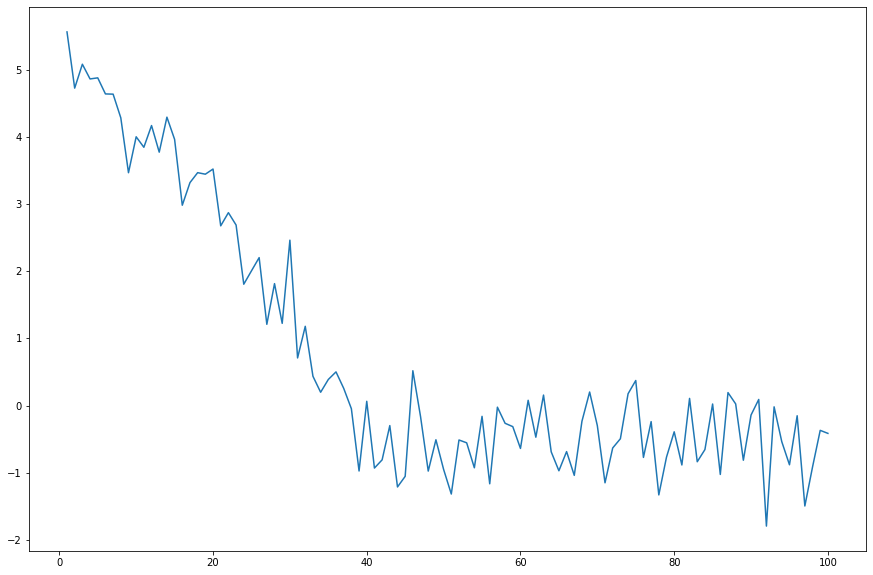

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(loss_hist[:, 0], loss_hist[:, 1])
plt.show()